In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

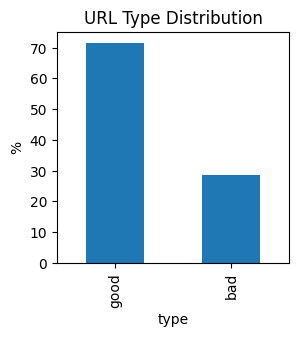

,url,type
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [11]:
data = pd.read_csv("phishing_site_urls.csv")

plt.figure(figsize=(3, 3))
data['type'].value_counts(normalize=True).mul(100).plot(kind='bar', title='URL Type Distribution')
plt.ylabel('%')
plt.show()
data.head()

In [4]:
vectorizer = HashingVectorizer(
    analyzer='char', 
    ngram_range=(3,5),
    n_features=2**20, 
    alternate_sign=False,
)
X = vectorizer.transform(data['url'])

In [5]:
le = LabelEncoder()
y = le.fit_transform(data['type'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 439476
Testing samples: 109870


In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, n_jobs=-1),
    "Multinomial NB": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Perceptron": Perceptron(max_iter=1000, n_jobs=-1),
}

In [10]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n🔹 {name} Accuracy: {acc*100:.2f}%")


🔹 Logistic Regression Accuracy: 96.86%

🔹 SGD Classifier Accuracy: 91.55%

🔹 Multinomial NB Accuracy: 94.59%

🔹 Linear SVM Accuracy: 98.63%

🔹 Perceptron Accuracy: 98.33%


In [12]:
print("\n=== Summary of Model Accuracies ===")
for model_name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name:<25} {acc*100:>6.2f}%")


=== Summary of Model Accuracies ===
Linear SVM                 98.63%
Perceptron                 98.33%
Logistic Regression        96.86%
Multinomial NB             94.59%
SGD Classifier             91.55%


In [13]:
best_model_name, best_acc = max(results.items(), key=lambda x: x[1])
best_model = models[best_model_name]
pipeline = make_pipeline(vectorizer, best_model)


Detailed Evaluation - Linear SVM
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     31285
           1       0.99      0.99      0.99     78585

    accuracy                           0.99    109870
   macro avg       0.99      0.98      0.98    109870
weighted avg       0.99      0.99      0.99    109870



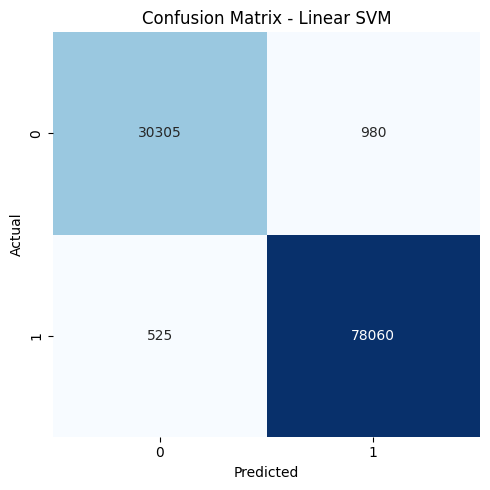

In [14]:
y_pred_best = best_model.predict(X_test)
print(f"\nDetailed Evaluation - {best_model_name}")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Loaded 49158 URLs from PhishTank for verification...

🔍 PhishTank Verification Results:
✅ Correctly flagged as 'bad' (malicious): 47539
❌ Misclassified as 'good': 1619
📊 Detection Accuracy: 96.71%


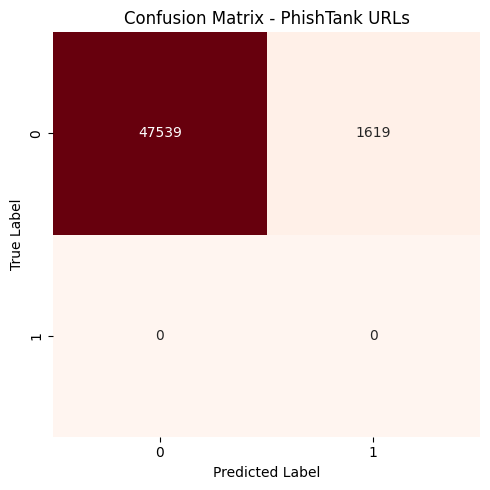

In [16]:
verify_df = pd.read_csv("verified_online.csv")
print(f"\nLoaded {len(verify_df)} URLs from PhishTank for verification...")

true_labels = [0] * len(verify_df)
y_verify_pred = pipeline.predict(verify_df["url"])
verify_acc = accuracy_score(true_labels, y_verify_pred)
false_negatives = sum(y_verify_pred == 1)

print(f"\n🔍 PhishTank Verification Results:")
print(f"✅ Correctly flagged as 'bad' (malicious): {len(verify_df) - false_negatives}")
print(f"❌ Misclassified as 'good': {false_negatives}")
print(f"📊 Detection Accuracy: {verify_acc * 100:.2f}%")

cm_verify = confusion_matrix(true_labels, y_verify_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_verify, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Confusion Matrix - PhishTank URLs")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
